Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


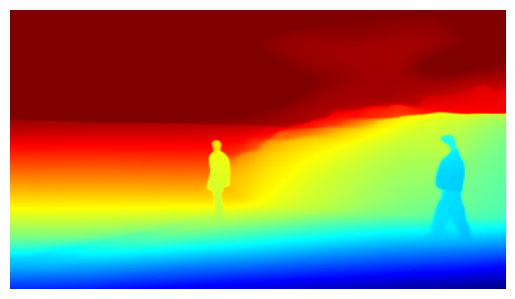

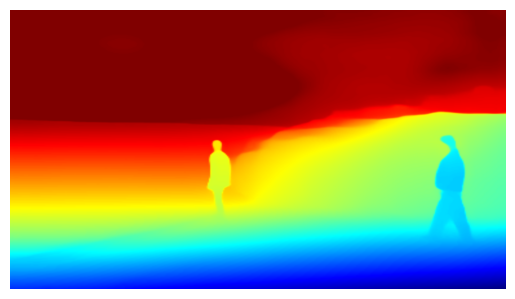

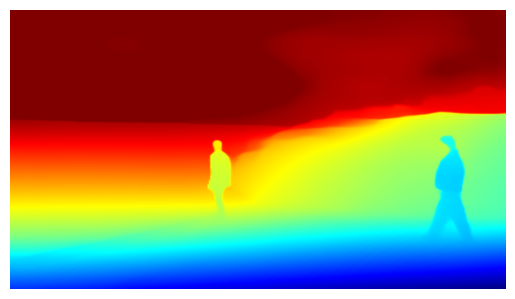

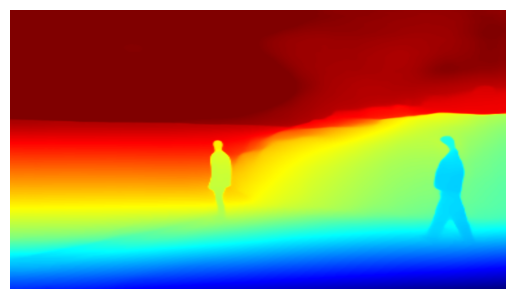

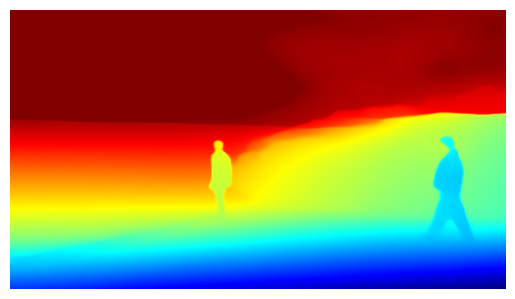

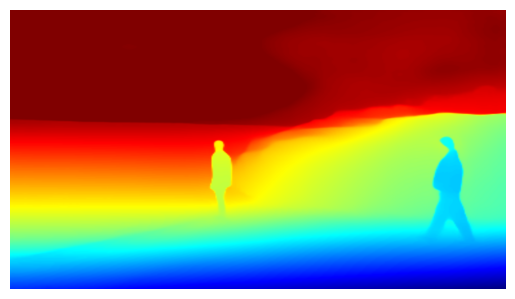

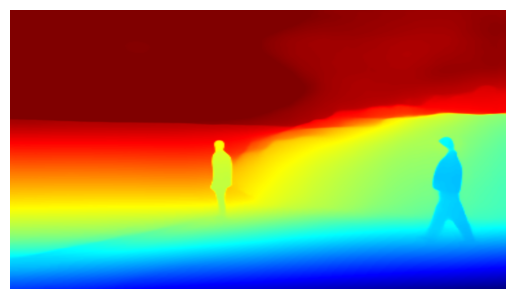

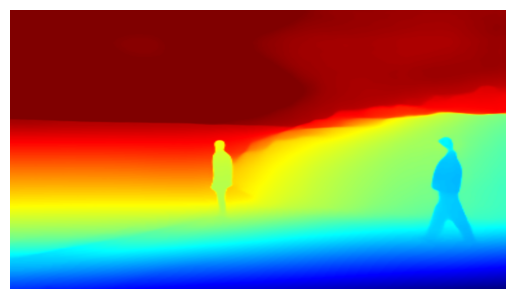

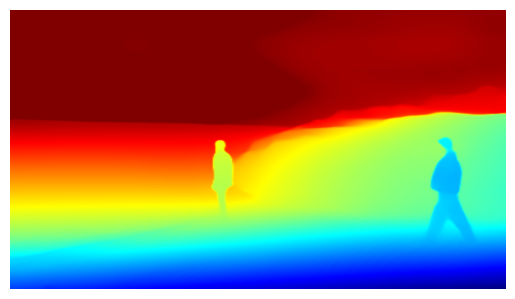

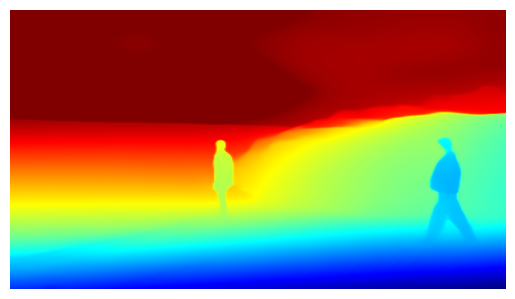

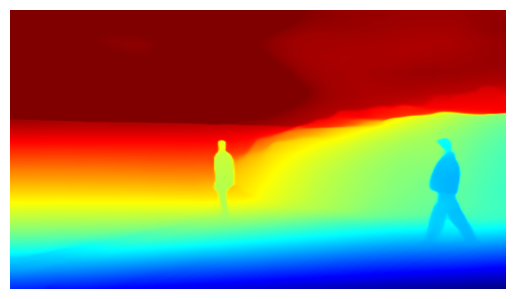

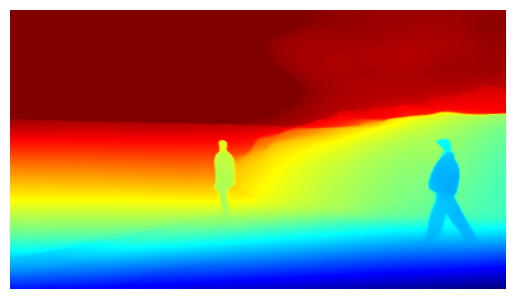

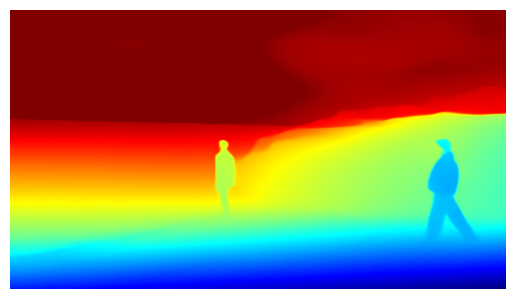

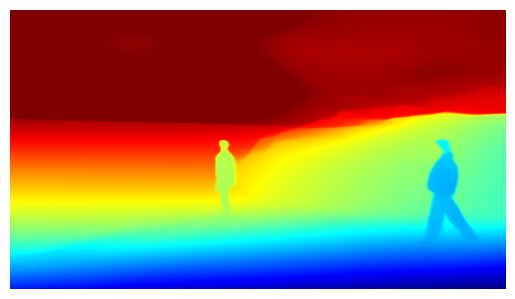

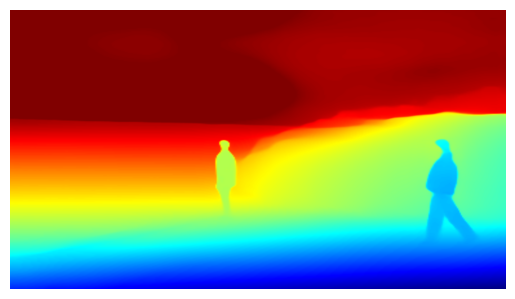

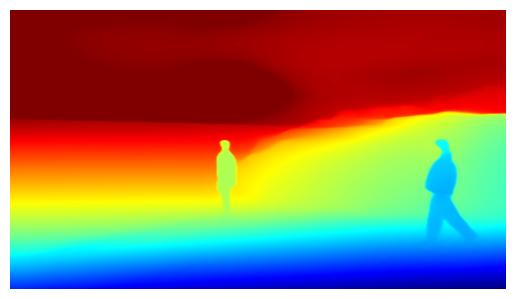

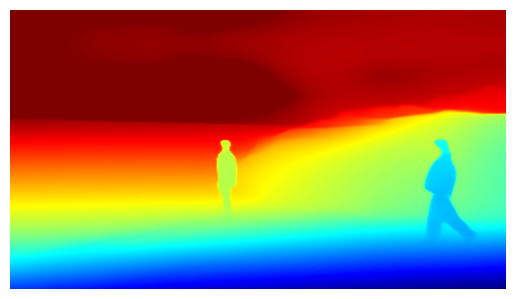

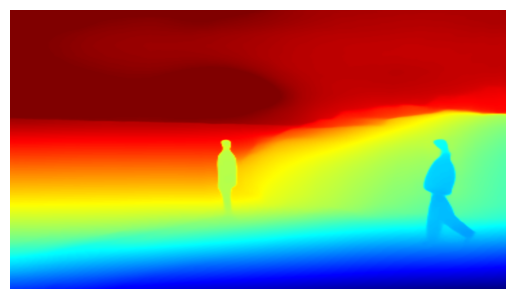

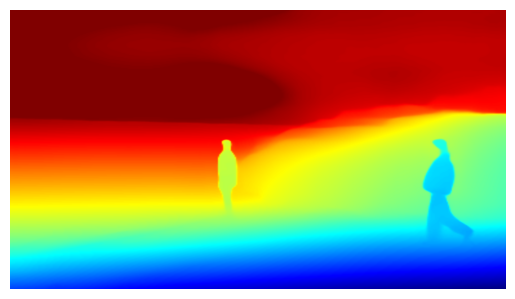

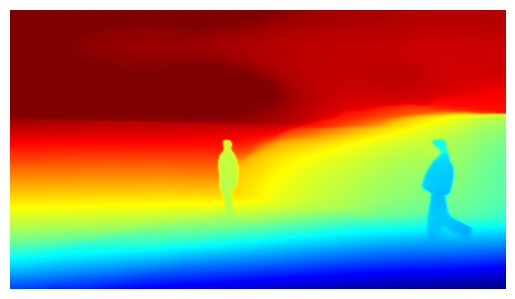

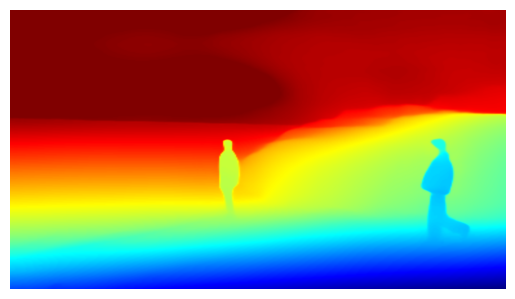

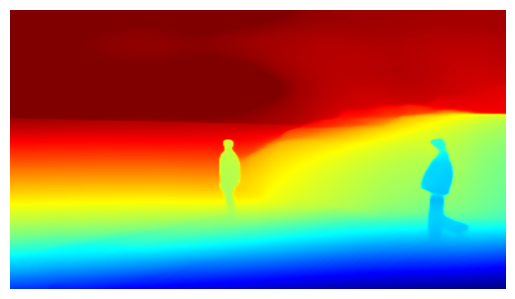

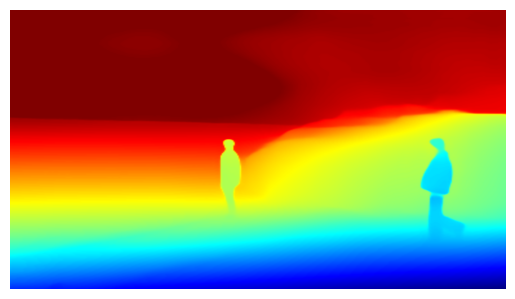

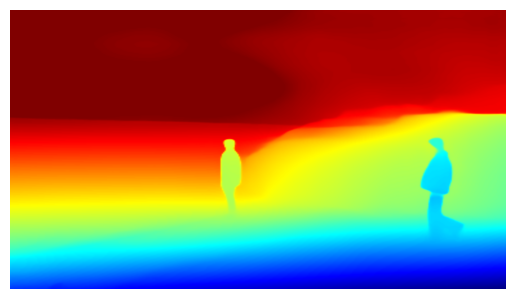

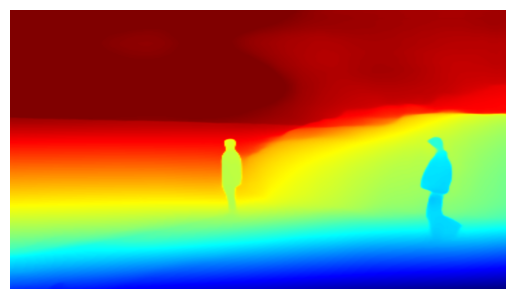

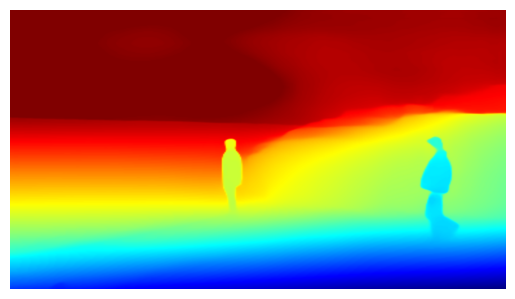

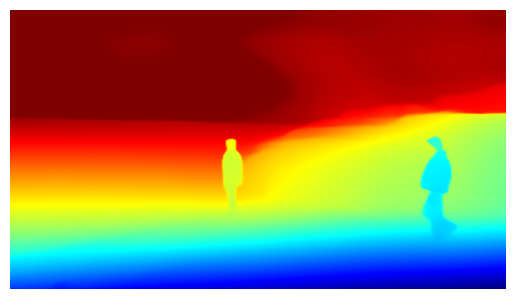

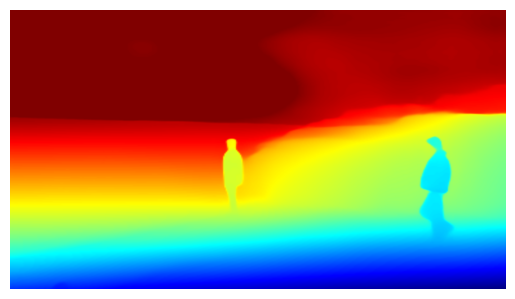

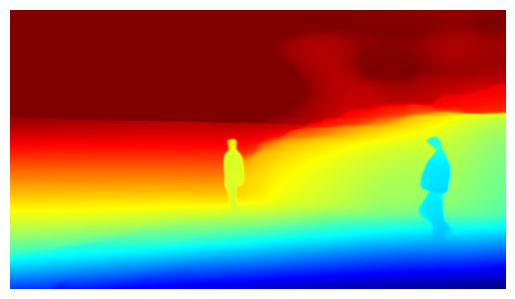

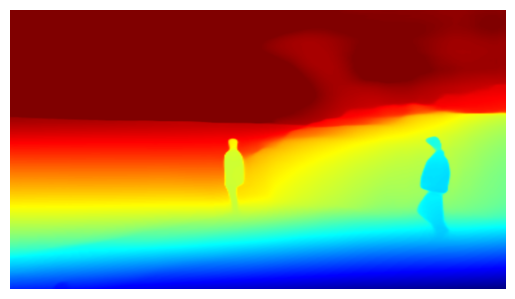

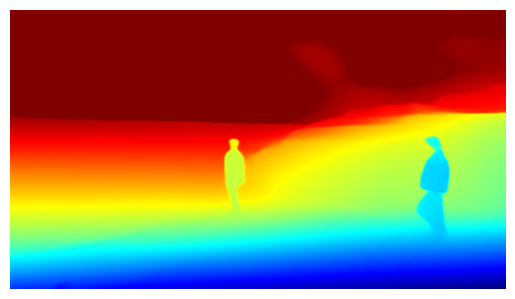

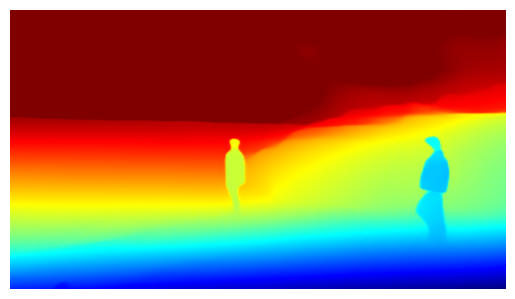

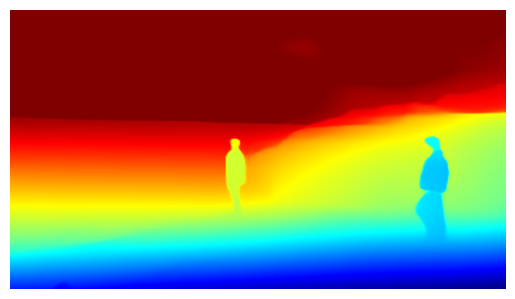

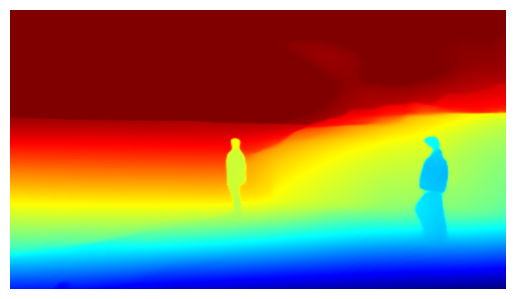

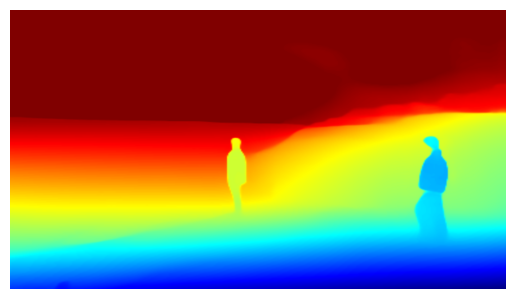

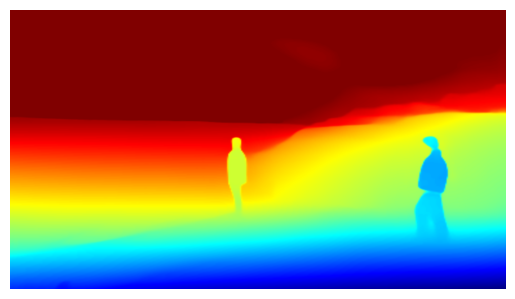

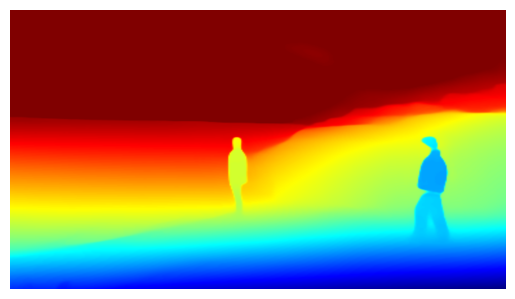

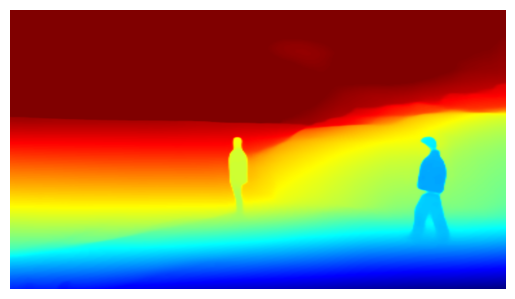

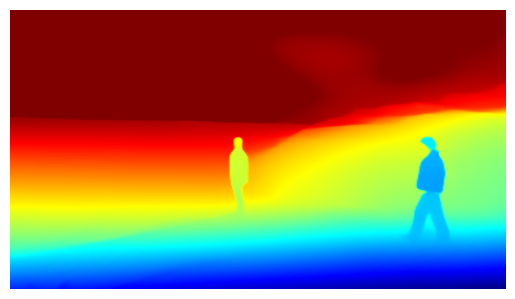

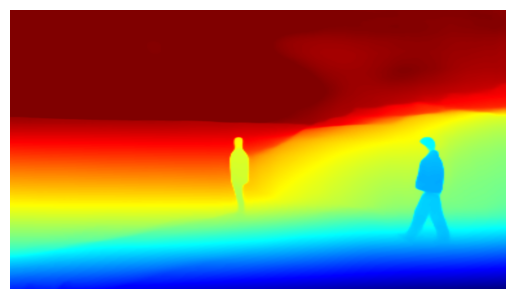

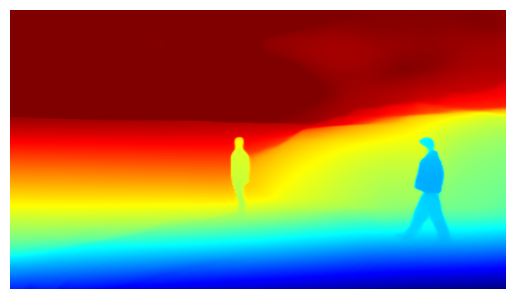

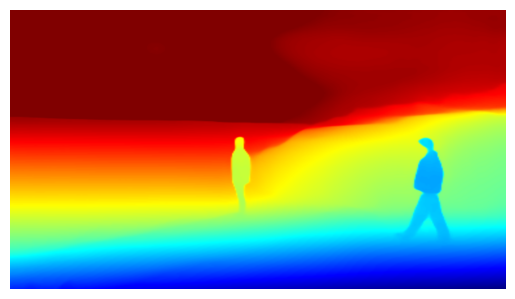

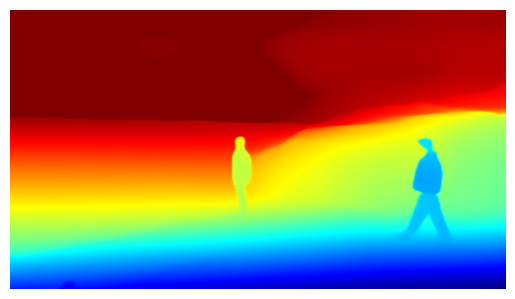

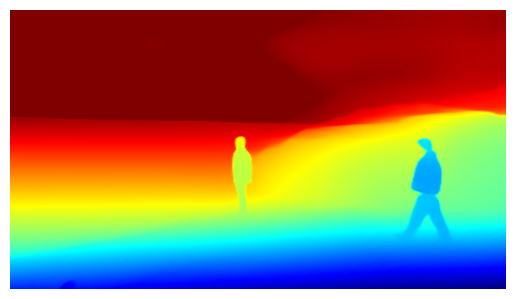

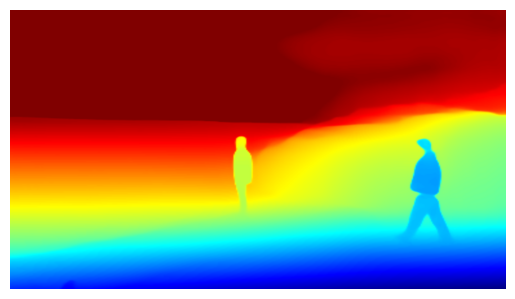

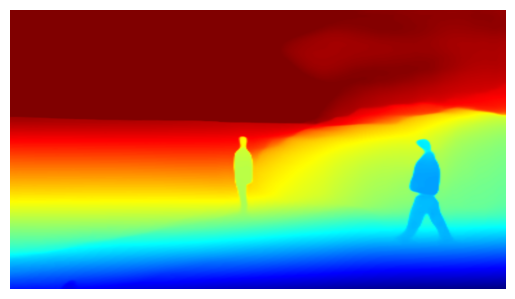

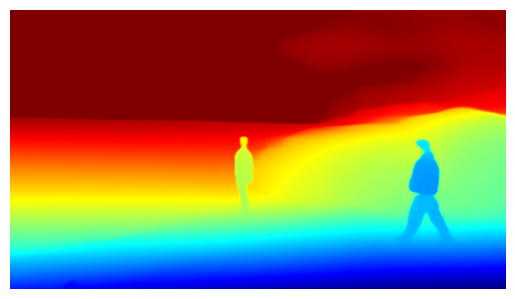

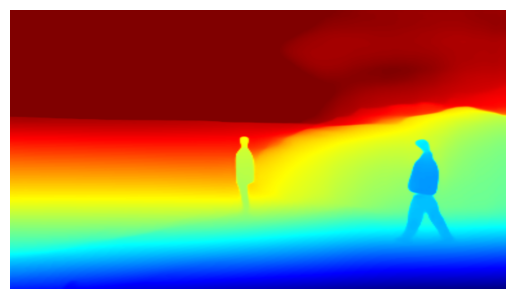

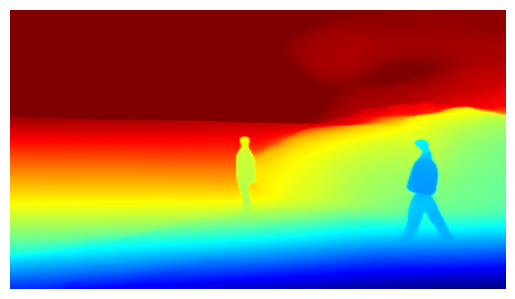

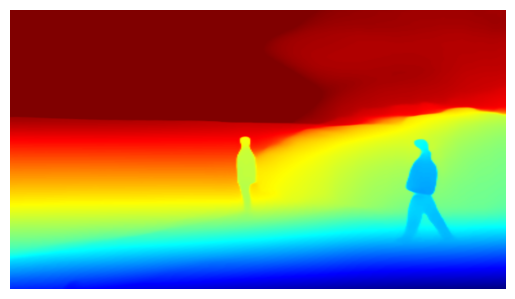

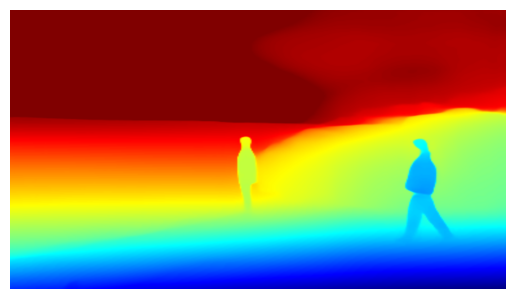

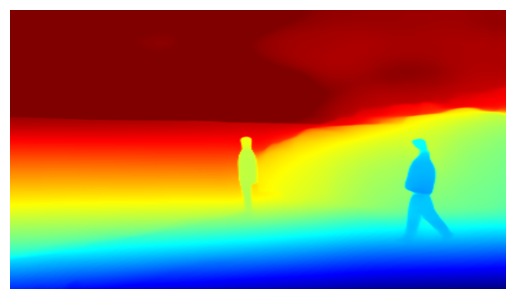

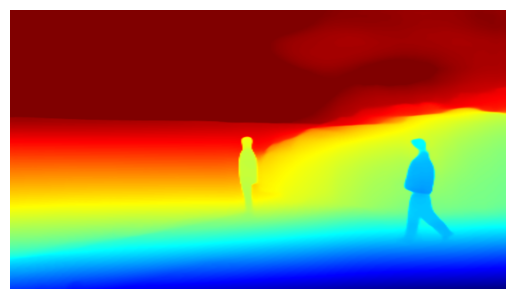

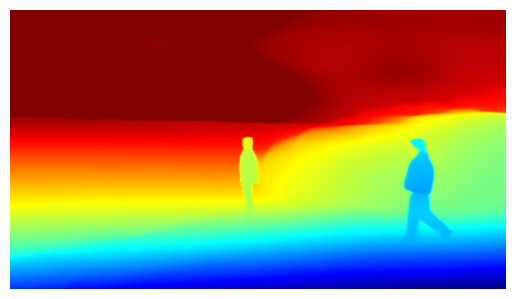

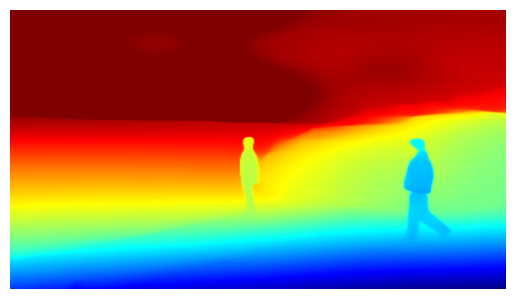

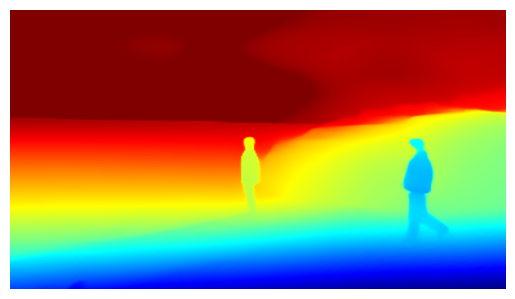

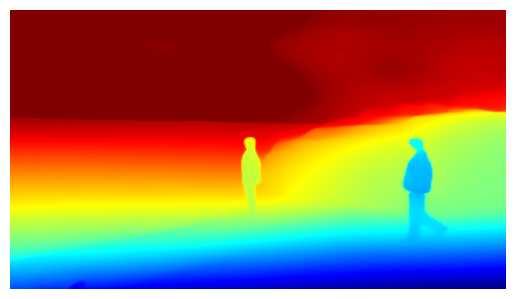

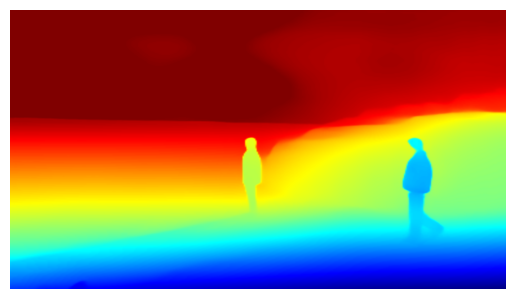

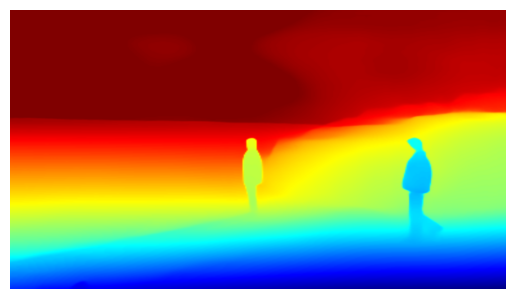

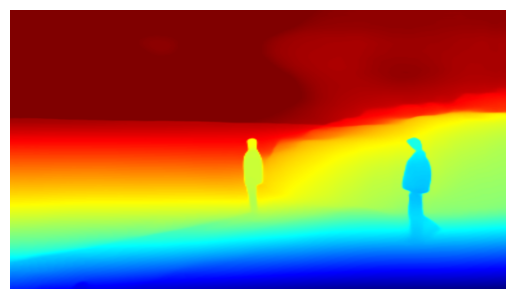

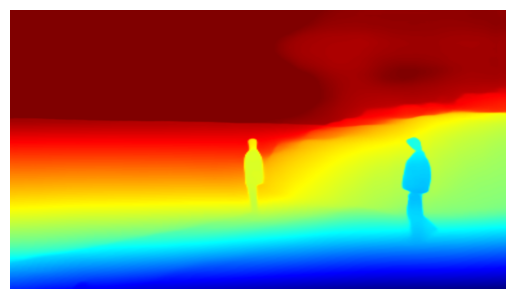

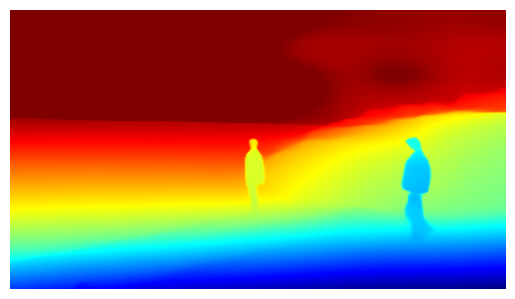

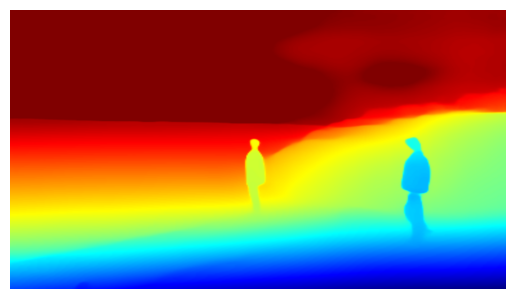

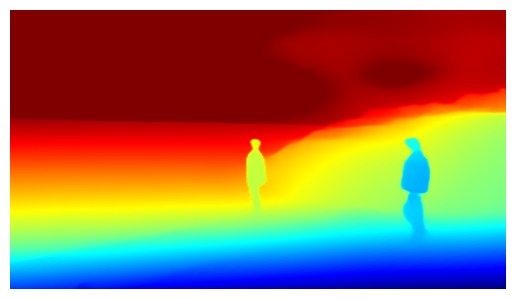

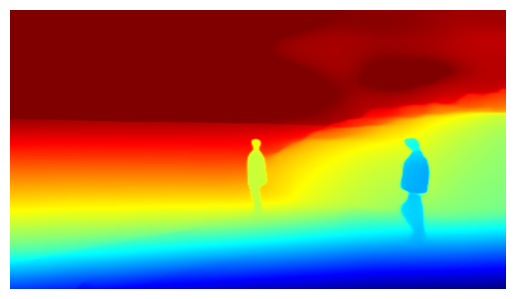

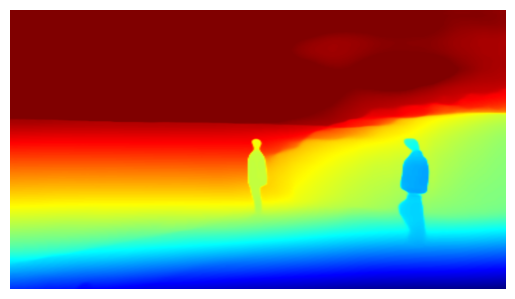

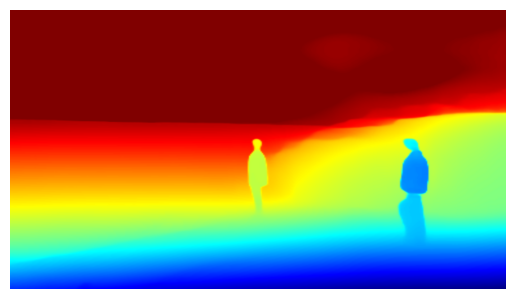

In [7]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from midas.dpt_depth import DPTDepthModel

# Загрузка предобученной модели MiDaS
model_type = "DPT_Large"  # Можно использовать "DPT_Hybrid" или "MiDaS_small"
model = torch.hub.load("intel-isl/MiDaS", model_type)
model.eval()

# Преобразования для входных изображений
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Измените размер в соответствии с моделью
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Функция для оценки глубины
def estimate_depth(frame):
    # Преобразование изображения
    input_tensor = transform(Image.fromarray(frame)).unsqueeze(0)

    # Перемещение на устройство (GPU или CPU)
    with torch.no_grad():
        depth_map = model(input_tensor)

    # Нормализация карты глубины для визуализации
    depth_map = depth_map.squeeze().cpu().numpy()
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())  # Нормализация
    return depth_map

# Визуализация глубины
def visualize_depth(depth_map):
    plt.imshow(depth_map, cmap='inferno')
    plt.axis('off')
    plt.show()

# Обработка видео
video_path = '/content/1112645_Approach_Winter-clothes_3840x2160 (online-video-cutter.com).mp4'  # Укажите путь к вашему видео
output_video_path = '/content/output_depth_video.mp4'
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
     # Получение параметров видео
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width * 2, height))
    # Оценка глубины
    depth_map = estimate_depth(frame)

    # Визуализация глубины
    depth_vis = (depth_map * 255).astype(np.uint8)
    depth_vis = cv2.applyColorMap(depth_vis, cv2.COLORMAP_JET)
    depth_vis = cv2.resize(depth_vis, (width, height))

    visualize_depth(depth_vis)
    combined_frame = np.hstack((frame, depth_vis))

        # Запись кадра в выходной файл
    out.write(combined_frame)

    # Отображение оригинального кадра (для сравнения)
    #cv2.imshow('Original Frame', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
